In [35]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import MinMaxScaler
import os

In [36]:
old_df = pd.read_csv('/kaggle/input/health-insurance-cross-sell-prediction-data/train.csv')
old_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [37]:
new_df = pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv')
new_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [38]:
old_df['Response'].value_counts()

Response
0    334399
1     46710
Name: count, dtype: int64

In [39]:
new_df['Response'].value_counts()

Response
0    10089739
1     1415059
Name: count, dtype: int64

In [40]:
old_df_1 = old_df[old_df['Response'] == 1]
df = pd.concat([new_df, old_df_1], ignore_index=True)

In [41]:
df['Response'].value_counts()

Response
0    10089739
1     1461769
Name: count, dtype: int64

In [42]:
df.drop(columns=['id'], inplace=True)

In [43]:
print("before drop duplicates : ", df.duplicated().sum())
df.drop_duplicates(inplace=True)
print("after drop duplicates : ", df.duplicated().sum())

before drop duplicates :  25
after drop duplicates :  0


In [45]:
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.head()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes
0,21,1,35.0,0,65101.0,124.0,187,0,True,False,False,True
1,43,1,28.0,0,58911.0,26.0,288,1,True,False,True,True
2,25,1,14.0,1,38043.0,152.0,254,0,False,True,False,False
3,35,1,1.0,0,2630.0,156.0,76,0,False,False,False,True
4,36,1,15.0,1,31951.0,152.0,294,0,False,False,False,False


In [55]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Define the pipeline
over = SMOTE(sampling_strategy=0.5)  # Adjust the ratio as needed
under = RandomUnderSampler(sampling_strategy=0.5)  # Adjust the ratio as needed
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
x = df_encoded.drop(columns=['Response'])
y = df_encoded['Response']
df_encoded, target = pipeline.fit_resample(x, y)

In [56]:
y_resamples.value_counts()

Response
0    10089738
1     5044869
Name: count, dtype: int64

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
scaler = MinMaxScaler()
numerical_features = ['Age', 'Annual_Premium', 'Vintage', 'Region_Code', 'Policy_Sales_Channel']
df_encoded[numerical_features] = scaler.fit_transform(df_encoded[numerical_features])
df_encoded.head()


,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes
0,0.015385,1,0.673077,0,0.116218,0.759259,0.612457,0,True,False,False,True
1,0.353846,1,0.538462,0,0.104702,0.154321,0.961938,1,True,False,True,True
2,0.076923,1,0.269231,1,0.065880,0.932099,0.844291,0,False,True,False,False
3,0.230769,1,0.019231,0,0.000000,0.956790,0.228374,0,False,False,False,True
4,0.246154,1,0.288462,1,0.054547,0.932099,0.982699,0,False,False,False,False


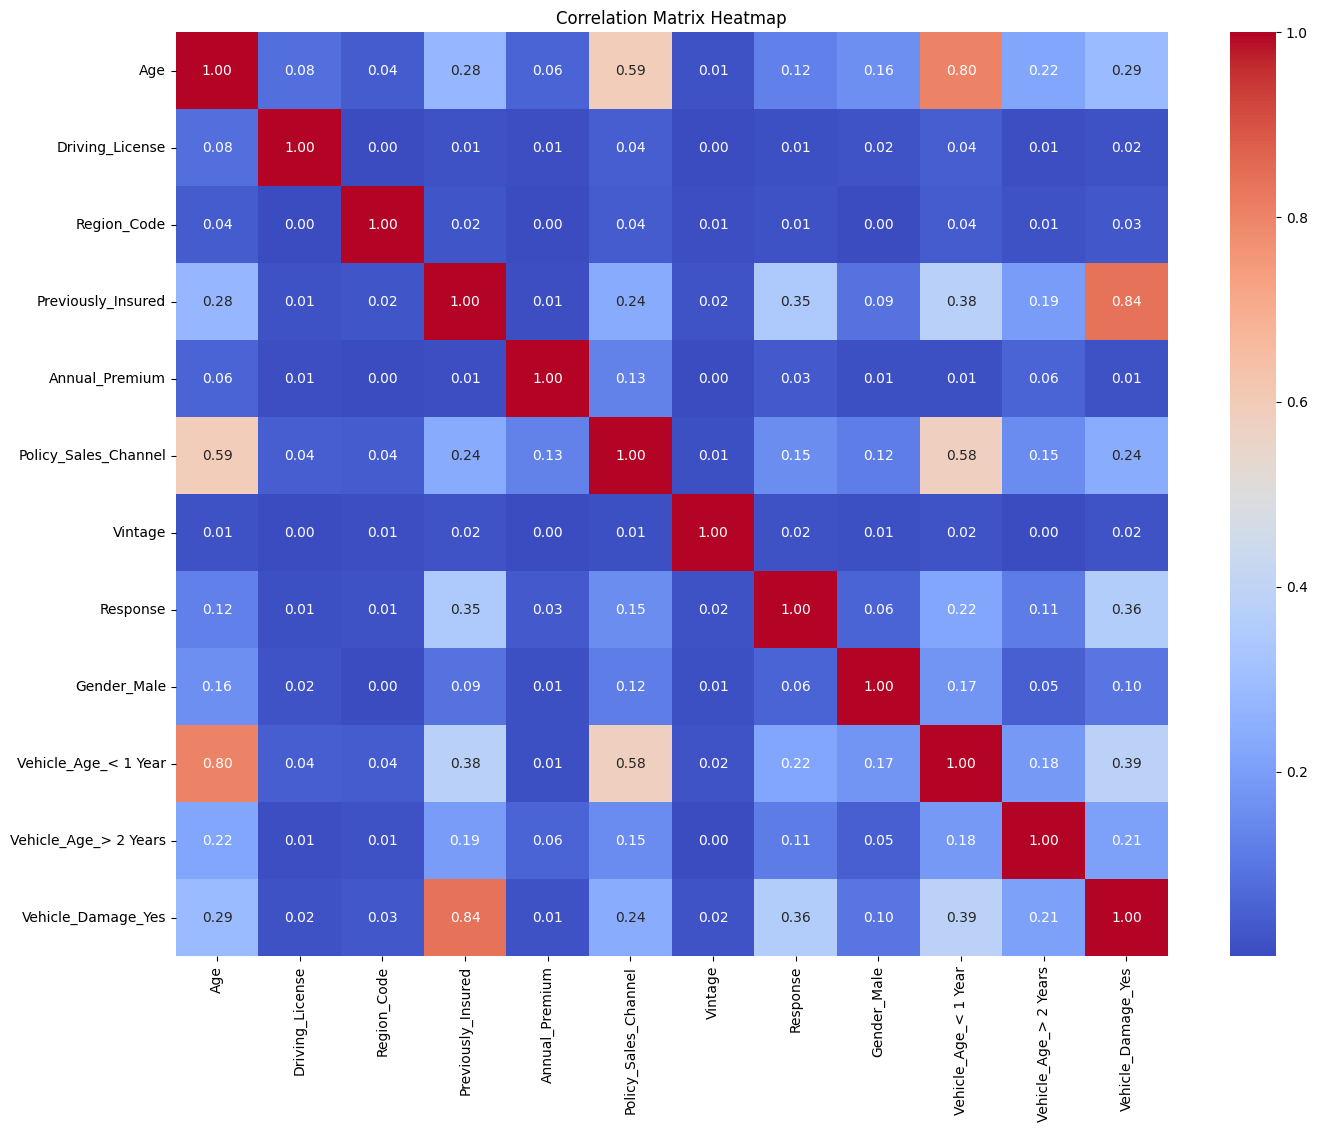

In [8]:
corr_matrix = df_encoded.corr().abs()
corr_matrix.head()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [11]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

In [9]:
threshold = 0.9
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print(to_drop)

['Driving_License', 'Region_Code', 'Annual_Premium', 'Vintage', 'Gender_Male']


In [10]:
df_final = df_encoded.drop(columns=to_drop)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
def train_and_evaluate_model(data, target, model):
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict probabilities for the test set
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    # Calculate the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    
    # Calculate the AUC score
    auc_score = roc_auc_score(y_test, y_pred_prob)
    
    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    return model

In [12]:
data = df_final

In [13]:
data.rename(columns={'Vehicle_Age_< 1 Year':'Vehicle_Age_less_1_Year', 'Vehicle_Age_> 2 Years':'Vehicle_Age_greater_2_Years'}, inplace=True)

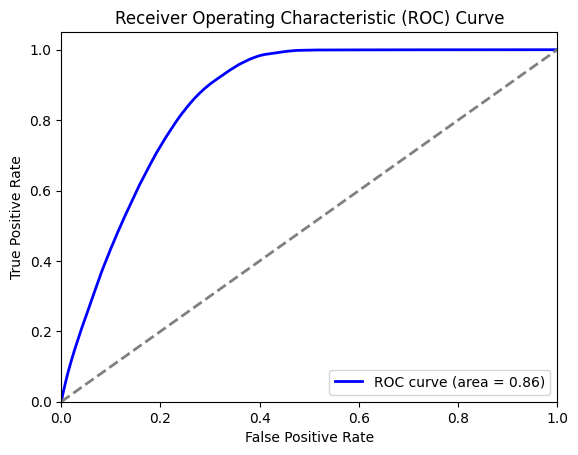

In [14]:
from catboost import CatBoostClassifier
catboost_model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, verbose=0)
catboost_model = train_and_evaluate_model(data, target, catboost_model)

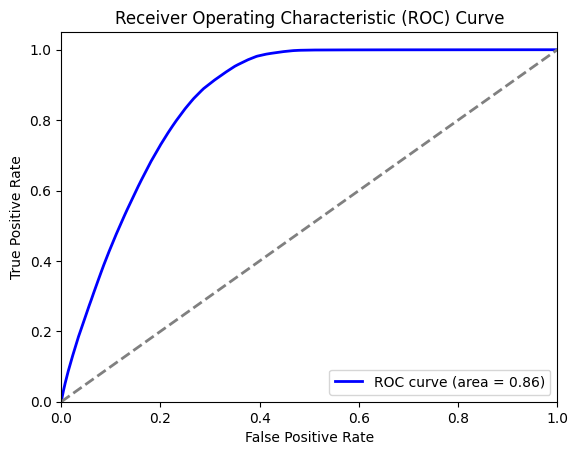

In [15]:
from xgboost import XGBClassifier
xgboost_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgboost_model = train_and_evaluate_model(data, target, xgboost_model)

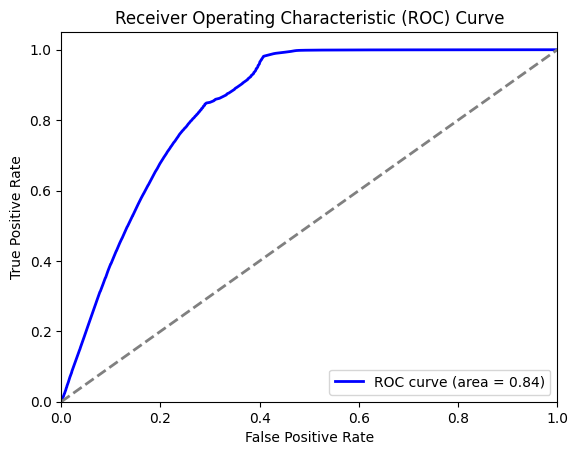

In [16]:
from sklearn.linear_model import LogisticRegression
logistic_regression_model = LogisticRegression(solver='liblinear', random_state=42)
logistic_regression_model = train_and_evaluate_model(data, target, logistic_regression_model)

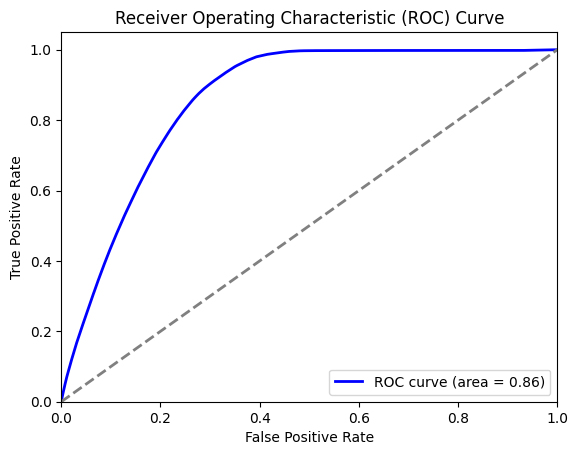

In [17]:
from sklearn.tree import DecisionTreeClassifier
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model = train_and_evaluate_model(data, target, decision_tree_model)

[LightGBM] [Info] Number of positive: 1131875, number of negative: 8071963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.224025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 179
[LightGBM] [Info] Number of data points in the train set: 9203838, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122979 -> initscore=-1.964521
[LightGBM] [Info] Start training from score -1.964521


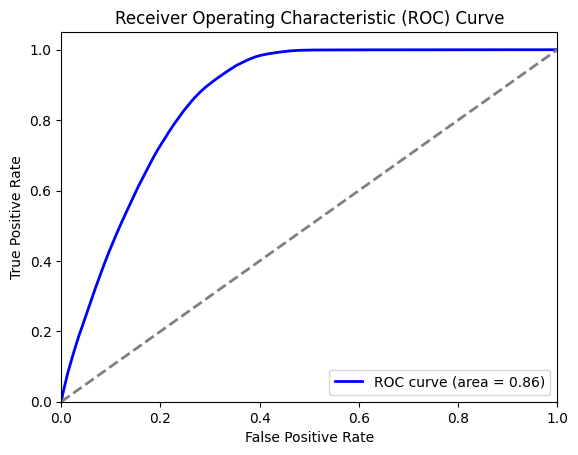

In [18]:
import lightgbm as lgb
lightgbm_model = lgb.LGBMClassifier(random_state=42)
lightgbm_model = train_and_evaluate_model(data, target, lightgbm_model)

In [19]:
def test_dataset(filename):
    test_df = pd.read_csv(filename)
    test_df.drop(columns=['id'], inplace=True)
    test_df_encoded = pd.get_dummies(test_df, drop_first=True)
    numerical_features = ['Age', 'Policy_Sales_Channel']
    test_df_encoded[numerical_features] = scaler.fit_transform(test_df_encoded[numerical_features])
    test_df_encoded.rename(columns={'Vehicle_Age_< 1 Year':'Vehicle_Age_less_1_Year', 'Vehicle_Age_> 2 Years':'Vehicle_Age_greater_2_Years'}, inplace=True)
    return test_df_encoded

In [20]:
test_data = test_dataset('/kaggle/input/playground-series-s4e7/test.csv')
predictions_1 = catboost_model.predict(test_data)

In [21]:
predictions_2 = xgboost_model.predict(test_data)

In [22]:
predictions_3 = logistic_regression_model.predict(test_data)

In [23]:
predictions_4 = decision_tree_model.predict(test_data)

In [24]:
predictions_5 = lightgbm_model.predict(test_data)

In [25]:
print(predictions_1)
print(predictions_2)
print(predictions_3)
print(predictions_4)
print(predictions_5)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


In [26]:
from scipy import stats
predictions = np.mean([predictions_1, predictions_2, predictions_3, predictions_4, predictions_5], axis=0)
print(predictions)

[0. 0. 0. ... 0. 0. 0.]


In [28]:
len(predictions)

7669866

In [27]:
id = pd.read_csv('/kaggle/input/playground-series-s4e7/test.csv')['id']
predictions_all = predictions
result = pd.DataFrame()
result['id'] = id
result['Response'] = predictions_all
result.to_csv('result_mean.csv', index=False)

In [ ]:
from sklearn.svm import SVC
svm_model = SVC(probability=True)
svm_model = train_and_evaluate_model(data, target, svm_model)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model = train_and_evaluate_model(data, target, random_forest_model)